# Proyecto final de Aprendizaje Automático
## Autor:
Daniel Useche.
ignaciousecheparedes@gmail.com

Raul Saavedra
raul.saavedra@unet.edu.ve

---
## Descripción
Aplicación de multiclasificadores tipo Bagging y Boosting a la data de pacientes diabéticos extraida de 130 hospitales de los Estados Unidos en el periodo comprendido entre 1999-2008.

El data set original puede encontrarse en el siguiente [enlace](https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008#) o en la dirección: https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008#

Para una explicación detallada de los atributos presentes en el dataset dirigirse a https://www.hindawi.com/journals/bmri/2014/781670/

---

## Objetivo 

Predecir bajo diferentes métodos, si dado la historia médica de un paciente es recomendable tratarlo únicamente con insulina o sumado a otros tipos de tratamientos.

## Cargando el DataSet 

In [82]:
import numpy as np
import pandas as pd 
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, f1_score, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')
diabeticDataSet = pd.read_csv("diabetic_data.csv", header = 0)
diabeticDataSet.tail()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
101761,443847548,100162476,AfricanAmerican,Male,[70-80),?,1,3,7,3,...,No,Down,No,No,No,No,No,Ch,Yes,>30
101762,443847782,74694222,AfricanAmerican,Female,[80-90),?,1,4,5,5,...,No,Steady,No,No,No,No,No,No,Yes,NO
101763,443854148,41088789,Caucasian,Male,[70-80),?,1,1,7,1,...,No,Down,No,No,No,No,No,Ch,Yes,NO
101764,443857166,31693671,Caucasian,Female,[80-90),?,2,3,7,10,...,No,Up,No,No,No,No,No,Ch,Yes,NO
101765,443867222,175429310,Caucasian,Male,[70-80),?,1,1,7,6,...,No,No,No,No,No,No,No,No,No,NO


---
## Preprocesado:

### Eliminación de caracteristicas ruidosas, o con valores faltantes:
Como todo conjunto de datos, el data set utilizado tiene atributos que poseen elementos faltantes en su mayoria, redundantes o ruidosos, como se muestra en la tabla 1 (pág 3) del [documento](https://www.hindawi.com/journals/bmri/2014/781670/) que describe los atributos, los siguientes atributos deben ser depurados del dataset por su cantidad de valores faltantes:
- weight: indica el peso del paciente, pero como su medida no es obligatoria, posee un aproximado de 97% de valores faltantes.
- payer_code: número que indica el tipo de pago realizado por el paciente, 40% de datos faltantes e irrelevante para el análisis.
- medical_specialty: indica la especialidad del médico que brindó la atención, posee 49% de datos faltantes.
- citoglipton, examide: Estas dos variables se eliminaron porque poseen los mismos valores a lo largo de todo dataset

In [83]:
diabeticDataSet = diabeticDataSet.drop(columns = ['weight', 'payer_code', 'medical_specialty'])

### Estableciendo un registro único por paciente:
Tambien hay que tomar en cuenta que puede existir mas de un registro para el mismo paciente, por lo que se tomará el atributo **patient_nbr** para filtrar los encuentros y así no existan pacientes duplicados:

In [84]:
diabeticDataSet = diabeticDataSet.drop_duplicates(subset='patient_nbr')

### Filtrando por asignación de medicamentos

Debido a que el objetivo es clasificar con base a los tratamientos prescritos, se eliminarán los registros donde no haya ningun tratamiento asignado

In [85]:
diabeticDataSet = diabeticDataSet[diabeticDataSet['diabetesMed'] != 'No']
diabeticDataSet.drop(columns = 'diabetesMed', inplace = True)

print(diabeticDataSet['citoglipton'].value_counts())
print()
print(diabeticDataSet['examide'].value_counts())

# Debido que a través de todo el dataset estos dos medicamento no son prescritos se eliminarán del dataset.
diabeticDataSet.drop(columns = ['citoglipton', 'examide'], inplace = True)

No    54319
Name: citoglipton, dtype: int64

No    54319
Name: examide, dtype: int64


### Otros medicamentos a parte de la insulina:

In [86]:
medications = [
    "metformin",
    "repaglinide",
    "nateglinide",
    "chlorpropamide",
    "glimepiride",
    "acetohexamide",
    "glipizide",
    "glyburide",
    "tolbutamide",
    "pioglitazone",
    "rosiglitazone",
    "acarbose",
    "miglitol",
    "troglitazone",
    "tolazamide",
    "glyburide-metformin",
    "glipizide-metformin",
    "glimepiride-pioglitazone",
    "metformin-rosiglitazone",
    "metformin-pioglitazone"]

### Separando los medicamentos alternos a la insulina

En esta etapa se reducen los 20 medicamentos restantes a una sola columna llamada **alt_medication** donde se expresa si tiene alguna medicación alternativa a la insulina.

In [87]:
medication_df = diabeticDataSet.loc[:, medications]

for col in medication_df.columns:
    medication_df[col].replace(['Up','Steady','Down'], 1, inplace = True)
    medication_df[col].replace('No', 0, inplace = True)

# Reducir la decicion de el tratamiento de insulina a si existe o no esta prescripción
# diabeticDataSet['insulin'].replace(['Up','Steady','Down'], 1, inplace = True)
# diabeticDataSet['insulin'].replace('No', 0, inplace = True)

diabeticDataSet['alt_medication'] = [1 if i > 0 else 0 for i in medication_df.sum(axis = 1, skipna = True)]

diabeticDataSet.drop(columns = medications, inplace = True)

## Filtrado de tipo de tratamiento

Se filtran el juego de datos donde solo existan registros donde se trataron pacientes con insulina o con otro tipo de tratamiento.

In [88]:
diabeticDataSet = diabeticDataSet[~((diabeticDataSet['insulin'] ==1) & (diabeticDataSet['alt_medication']==1))]


### Vista preliminar del dataset:

In [89]:
diabeticDataSet.T

,1,2,3,4,5,6,7,8,9,10,...,101745,101748,101749,101751,101752,101753,101754,101755,101756,101758
encounter_id,149190,64410,500364,16680,35754,55842,63768,12522,15738,28236,...,443797076,443811536,443816024,443835140,443835512,443841992,443842016,443842022,443842070,443842340
patient_nbr,55629189,86047875,82442376,42519267,82637451,84259809,114882984,48330783,63555939,89869032,...,183766055,189481478,106392411,175326800,139605341,184875899,183087545,188574944,140199494,120975314
race,Caucasian,AfricanAmerican,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,AfricanAmerican,...,Caucasian,Caucasian,Caucasian,Caucasian,Other,Other,Caucasian,Other,Other,Caucasian
gender,Female,Female,Male,Male,Male,Male,Male,Female,Female,Female,...,Male,Female,Female,Male,Female,Male,Female,Female,Female,Female
age,[10-20),[20-30),[30-40),[40-50),[50-60),[60-70),[70-80),[80-90),[90-100),[40-50),...,[50-60),[40-50),[70-80),[70-80),[40-50),[40-50),[70-80),[40-50),[60-70),[80-90)
admission_type_id,1,1,1,1,2,3,1,2,3,1,...,2,1,3,3,3,1,1,1,1,1
discharge_disposition_id,1,1,1,1,1,1,1,1,3,1,...,1,4,6,6,1,1,1,1,1,1
admission_source_id,7,7,7,7,2,2,7,4,4,7,...,1,7,1,1,1,7,7,7,7,7
time_in_hospital,3,2,2,1,3,4,5,13,12,9,...,3,14,3,13,3,13,9,14,2,5
num_lab_procedures,59,11,44,51,31,70,73,68,33,47,...,57,69,27,77,13,51,50,73,46,76


### Transformación de valores faltantes con el formato '?' a un valor compatible Nan
La Mayoría de los algoritmos de aprendizaje requieren que sus entradas no posean valores faltantes, y no funcionarán si este requerimiento es violado [ref](https://scikit-learn.org/stable/modules/impute.html#impute).

In [90]:
diabeticDataSet = diabeticDataSet.replace('?', np.nan)

### Imputación

Cuando los arrays son flotantes la estrategia predilecta de Sklearn para valores faltantes es Nan, sin embargo, debido a que la mayoria de campos en en el dataset son de tipo entero, debe tomarse otra aproximación para la data faltante, la estrategia preferida por la librería se llama [Imputation](https://scikit-learn.org/stable/modules/impute.html#impute) donde se escoge un valor representativo de todo el dataset y se agrega en los campos faltantes, estos valores pueden ser:
- el promedio de valores de la columna (`strategy = "mean"`)
- la media de los valores de la columna (`strategy = "median"`)
- la moda de los valores de la columna (`strategy = "most_frequent"`)
- una constante que se asigna con el parámetro **fill_value** (`strategy = "constant", fill_value = 0`)

In [91]:
for col in diabeticDataSet.columns:
    imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    imp.fit(diabeticDataSet[[col]])
    diabeticDataSet[col] = imp.fit_transform(diabeticDataSet[[col]])
diabeticDataSet

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,...,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,insulin,change,readmitted,alt_medication
1,149190,55629189,Caucasian,Female,[10-20),1,1,7,3,59,...,276,250.01,255,9,None,None,Up,Ch,>30,0
2,64410,86047875,AfricanAmerican,Female,[20-30),1,1,7,2,11,...,648,250,V27,6,None,None,No,No,NO,1
3,500364,82442376,Caucasian,Male,[30-40),1,1,7,2,44,...,8,250.43,403,7,None,None,Up,Ch,NO,0
4,16680,42519267,Caucasian,Male,[40-50),1,1,7,1,51,...,197,157,250,5,None,None,Steady,Ch,NO,1
5,35754,82637451,Caucasian,Male,[50-60),2,1,2,3,31,...,414,411,250,9,None,None,Steady,No,>30,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101753,443841992,184875899,Other,Male,[40-50),1,1,7,13,51,...,250.8,730,731,9,None,None,Down,Ch,NO,1
101754,443842016,183087545,Caucasian,Female,[70-80),1,1,7,9,50,...,574,574,250.02,9,None,>7,Steady,Ch,>30,1
101755,443842022,188574944,Other,Female,[40-50),1,1,7,14,73,...,592,599,518,9,None,>8,Up,Ch,>30,1
101756,443842070,140199494,Other,Female,[60-70),1,1,7,2,46,...,996,585,403,9,None,None,Steady,No,>30,0


### discharge_disposition_id

Este parámetro sirve para distinguir los pacientes muertos o descartados a hospicio (pacientes con estatus terminal que ya no ameritan cuidado médico de la enfermedad sino solo tratamiento para los dolores o sintomas asociados) que no se tomarán el cuenta para el análisis

- 11 Expired
- 13 Hospice / home
- 14 Hospice / medical facility
- 19 "Expired at home. Medicaid only, hospice."
- 20 "Expired in a medical facility. Medicaid only, hospice."
- 21 "Expired, place unknown. Medicaid only, hospice."


In [92]:
# Descartando pacientes muertos.
diabeticDataSet = diabeticDataSet[diabeticDataSet.discharge_disposition_id != 11]

# Descartando pacientes terminales enviados al hogar.
diabeticDataSet = diabeticDataSet[diabeticDataSet.discharge_disposition_id != 13]

# Descartando pacientes terminales enviados a instituciones médicas.
diabeticDataSet = diabeticDataSet[diabeticDataSet.discharge_disposition_id != 14]

# Descartando pacientes muertos en casa.
diabeticDataSet = diabeticDataSet[diabeticDataSet.discharge_disposition_id != 19]

# Descartando pacientes muertos en instituciones médicas.
diabeticDataSet = diabeticDataSet[diabeticDataSet.discharge_disposition_id != 20]

# Descartando pacientes muertos en otras condiciones.
diabeticDataSet = diabeticDataSet[diabeticDataSet.discharge_disposition_id != 21]
diabeticDataSet.T

,1,2,3,4,5,6,7,8,9,10,...,101745,101748,101749,101751,101752,101753,101754,101755,101756,101758
encounter_id,149190,64410,500364,16680,35754,55842,63768,12522,15738,28236,...,443797076,443811536,443816024,443835140,443835512,443841992,443842016,443842022,443842070,443842340
patient_nbr,55629189,86047875,82442376,42519267,82637451,84259809,114882984,48330783,63555939,89869032,...,183766055,189481478,106392411,175326800,139605341,184875899,183087545,188574944,140199494,120975314
race,Caucasian,AfricanAmerican,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,AfricanAmerican,...,Caucasian,Caucasian,Caucasian,Caucasian,Other,Other,Caucasian,Other,Other,Caucasian
gender,Female,Female,Male,Male,Male,Male,Male,Female,Female,Female,...,Male,Female,Female,Male,Female,Male,Female,Female,Female,Female
age,[10-20),[20-30),[30-40),[40-50),[50-60),[60-70),[70-80),[80-90),[90-100),[40-50),...,[50-60),[40-50),[70-80),[70-80),[40-50),[40-50),[70-80),[40-50),[60-70),[80-90)
admission_type_id,1,1,1,1,2,3,1,2,3,1,...,2,1,3,3,3,1,1,1,1,1
discharge_disposition_id,1,1,1,1,1,1,1,1,3,1,...,1,4,6,6,1,1,1,1,1,1
admission_source_id,7,7,7,7,2,2,7,4,4,7,...,1,7,1,1,1,7,7,7,7,7
time_in_hospital,3,2,2,1,3,4,5,13,12,9,...,3,14,3,13,3,13,9,14,2,5
num_lab_procedures,59,11,44,51,31,70,73,68,33,47,...,57,69,27,77,13,51,50,73,46,76


### Categorización de los diagnosticos presentes en el dataset

Las columnas diag_1,diag_2 y diag_3, presentan valores numéricos que pueden ser relacionados con diagnósticos médicos que reducen en gran cantidad las posibles clases en cada una de las columnas.

In [93]:
def ICD9(x):
    if 'V' in str(x):
        return 'Supplementary Classification of External Causes of Injury and Poisoning'
    elif "E" in str(x):
        return 'Supplementary Classification of Factors influencing Health Status and Contact with Health Services'
    num = int(float(x))
    if num >= 0 and num <= 139:
        return "Infectious and Parasitic Diseases"
    if num >=140 and num<= 239:
        return 'Neoplasms'
    if num >= 240 and num<= 279:
        return 'Endocrine, Nutritional and Metabolic Diseases, and Immunity Disorders'
    if num >=280 and num<=289:
        return 'Diseases of the Blood and Blood-forming Organs'
    if num >=290 and num<=319:
        return 'Mental Disorders'
    if num >=320 and num<=389:
        return 'Diseases of the Nervous System and Sense Organs'
    if num >= 390 and num<= 459:
        return 'Diseases of the Circulatory System'
    if num >=460 and num<= 519:
        return 'Diseases of the Respiratory System'
    if num >= 520 and num<= 579:
        return 'Diseases of the Digestive System'
    if num >=580 and num<= 629:
        return 'Diseases of the Genitourinary System'
    if num >= 630 and num<= 679:
        return 'Complications of Pregnancy, Childbirth, and the Puerperium'
    if num >= 680 and num<= 709:
        return 'Diseases of the Skin and Subcutaneous Tissue'
    if num>=710 and num<= 739:
        return 'Diseases of the Musculoskeletal System and Connective Tissue'
    if num >=740 and num<=759:
        return 'Congenital Anomalies'
    if num >=760 and num<=779:
        return 'Certain Conditions originating in the Perinatal Period'
    if num >=780 and num<= 799:
        return 'Symptoms, Signs and Ill-defined Conditions'
    if num>=800 and num<= 999:
        return 'Injury and Poisoning'
    else:
        return 'Others'

In [94]:
diabeticDataSet['diag_1'] = diabeticDataSet['diag_1'].apply(ICD9)
diabeticDataSet['diag_2'] = diabeticDataSet['diag_2'].apply(ICD9)
diabeticDataSet['diag_3'] = diabeticDataSet['diag_3'].apply(ICD9)


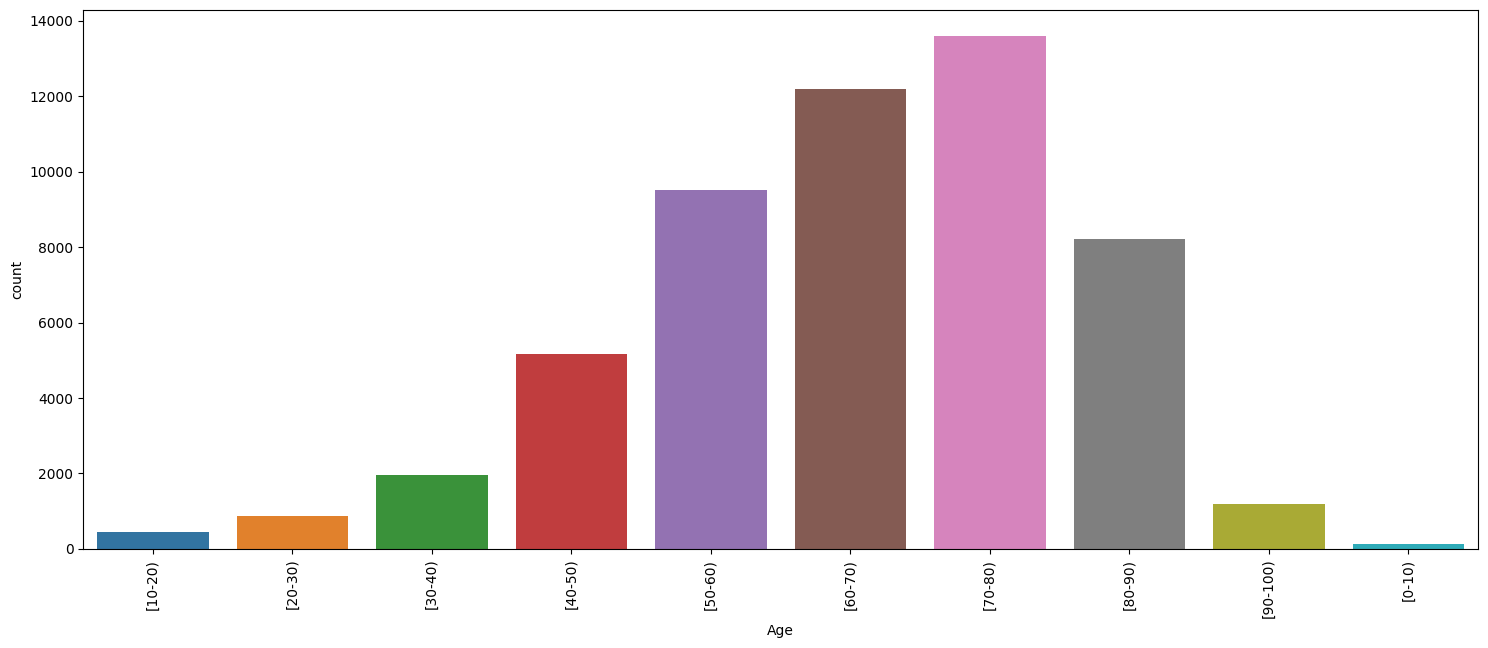

In [95]:
f, ax = plt.subplots(figsize = (18,7))
sns.countplot(diabeticDataSet['age'])
plt.xticks(rotation = 90)
plt.xlabel('Age')
plt.show()

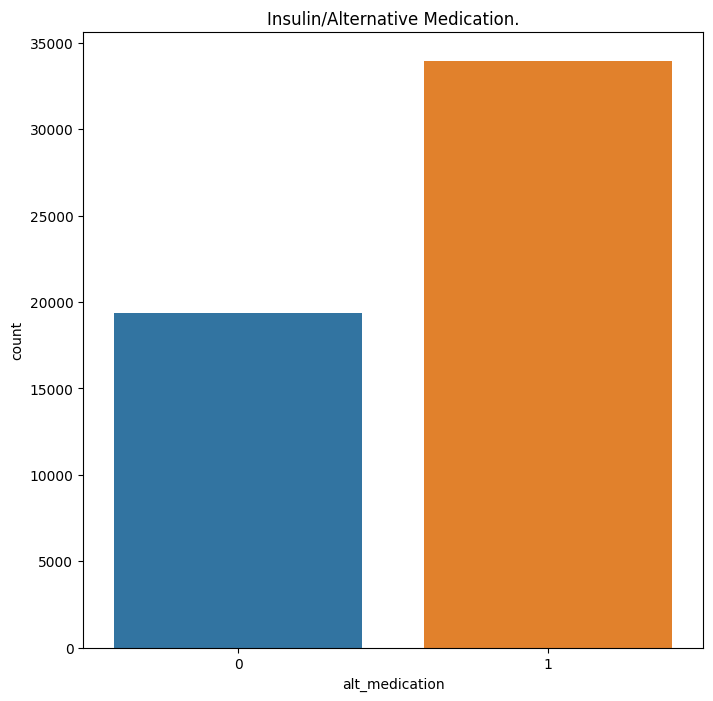

In [96]:
f, ax = plt.subplots(figsize = (8,8))
sns.countplot(diabeticDataSet['alt_medication'])
plt.title("Insulin/Alternative Medication.")
plt.show()

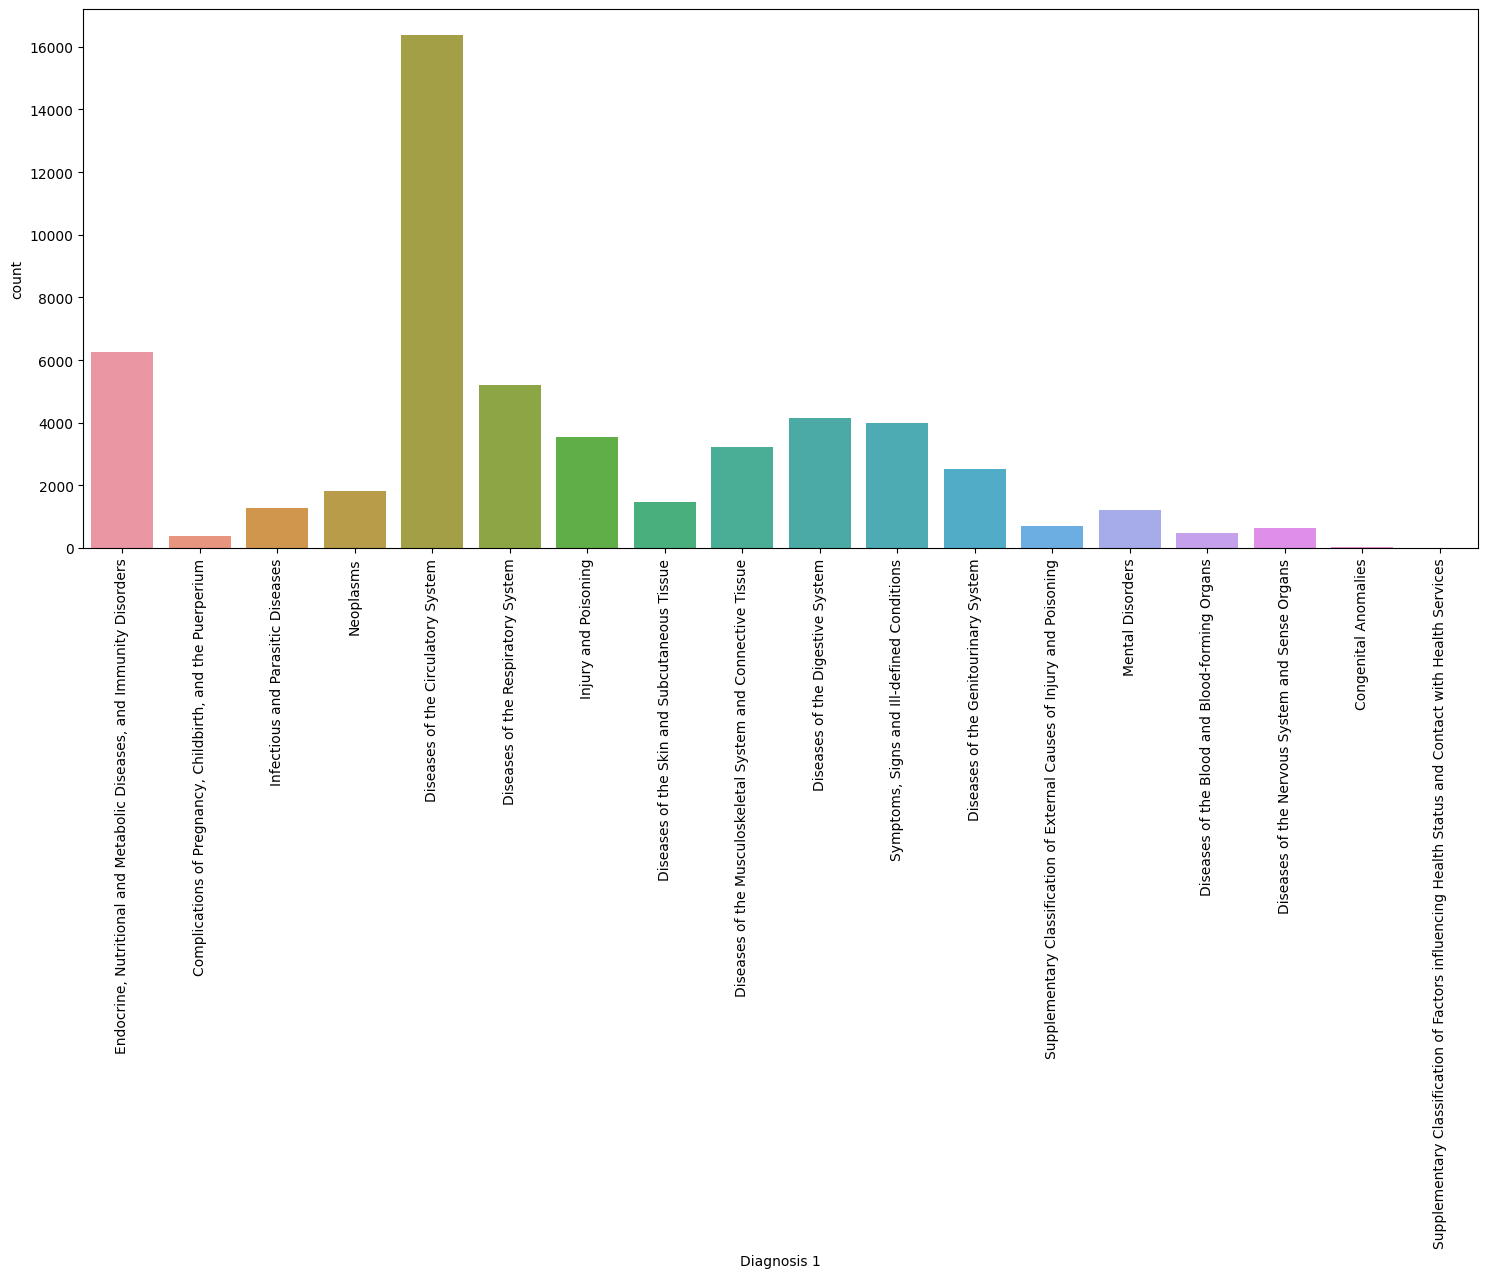

In [97]:
f, ax = plt.subplots(figsize = (18,7))
sns.countplot(diabeticDataSet['diag_1'])
plt.xticks(rotation = 90)
plt.xlabel('Diagnosis 1')
plt.show()

### Codificación del dataset

Los algorimos de aprendizaje de la librería trabajan con valores numéricos, debido a esto se tomo la opción de [codificar los atributos nominales](https://scikit-learn.org/stable/modules/preprocessing.html#encoding-categorical-features).

El estimador a utilizar es el `OrdinalEncoder()` el cual convierte cada categoría presente en una columna en un entero representativo.

In [98]:
origDiabeticDataSet = diabeticDataSet.copy()
for col in diabeticDataSet.columns:
    if diabeticDataSet[col].dtypes == 'object':
        enc = preprocessing.OrdinalEncoder()
        enc.fit(diabeticDataSet[[col]])
        diabeticDataSet[col] = enc.transform(diabeticDataSet[[col]])

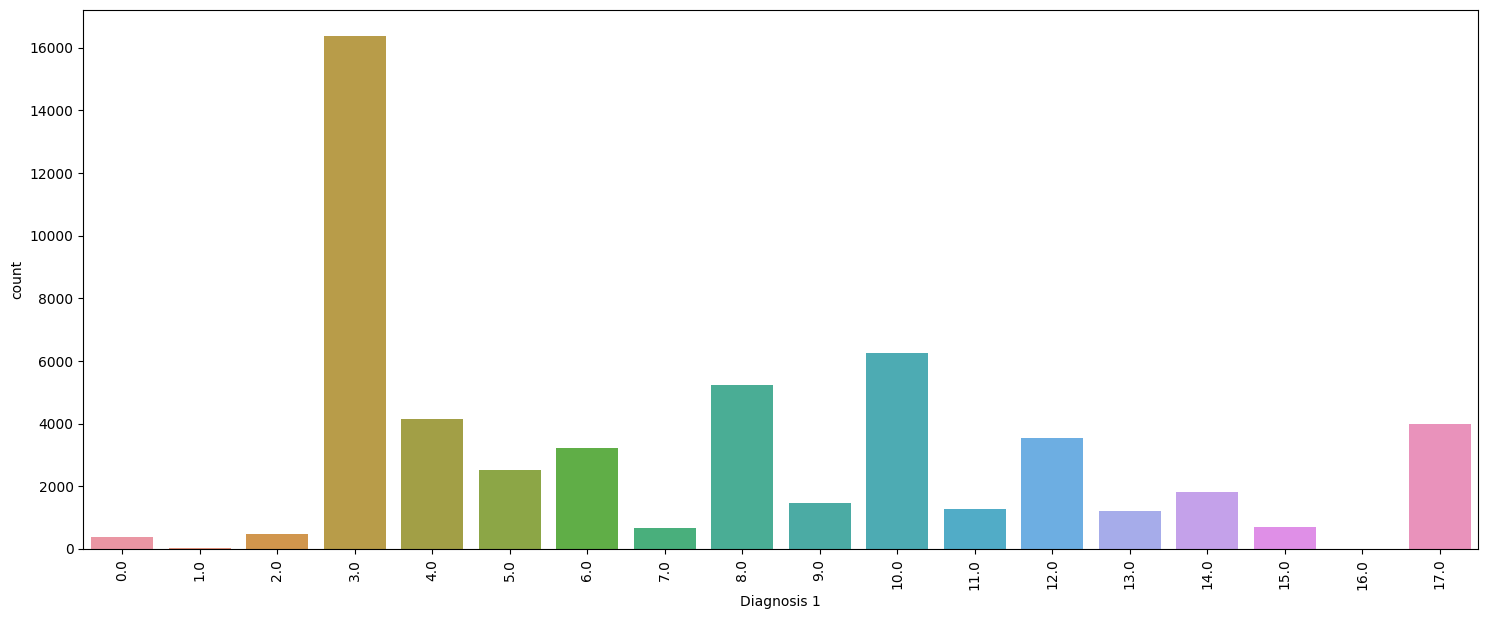

In [99]:
f, ax = plt.subplots(figsize = (18,7))
sns.countplot(diabeticDataSet['diag_1'])
plt.xticks(rotation = 90)
plt.xlabel('Diagnosis 1')
plt.show()

In [100]:
pd.DataFrame.to_csv(diabeticDataSet, "encodeddataPreprocesada.csv")
pd.DataFrame.to_csv(origDiabeticDataSet, "dataPreprocesada.csv")

---
## Aplicación de multiclasificadores

In [101]:
X = diabeticDataSet.drop(['alt_medication'], axis=1)
y = diabeticDataSet['alt_medication'].T
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 0)
print('X_train shape: ', X_train.shape)
print('x_test shape: ', X_test.shape)
print('y_train shape: ', y_train.shape)
print('y_test shape: ', y_test.shape)


X_train shape:  (42634, 24)
x_test shape:  (10659, 24)
y_train shape:  (42634,)
y_test shape:  (10659,)


In [102]:
l_model = LogisticRegression()
l_model.fit(X_train, y_train)
y_pred_l_model = l_model.predict(X_test)
acc_score_l_model = accuracy_score(y_test, y_pred_l_model)
roc_auc_score_l_model = roc_auc_score(y_test, y_pred_l_model, multi_class='ovo')
f1_l_model = f1_score(y_test, y_pred_l_model)


In [103]:
print('---------- Estadisticas Generales para Logistic Regression ----------')
print('---------------------------------------------------------------------\n')
print('---------- Reporte de clasificacion ----------')
print(classification_report(y_test, y_pred_l_model))
print('---------- Matriz de confusion ----------')
print(confusion_matrix(y_test, y_pred_l_model))
print('---------- Otras estadisticas ----------')
print('Overall Accuracy: ', round(acc_score_l_model, 3))
print('Overall ROC-Area: ', round(roc_auc_score_l_model, 3))
print('Overall F1-Score: ', round(f1_l_model, 3))


---------- Estadisticas Generales para Logistic Regression ----------
---------------------------------------------------------------------

---------- Reporte de clasificacion ----------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3838
           1       0.64      1.00      0.78      6821

    accuracy                           0.64     10659
   macro avg       0.32      0.50      0.39     10659
weighted avg       0.41      0.64      0.50     10659

---------- Matriz de confusion ----------
[[   0 3838]
 [   0 6821]]
---------- Otras estadisticas ----------
Overall Accuracy:  0.64
Overall ROC-Area:  0.5
Overall F1-Score:  0.78


### Utilizando metodo Boosting

In [104]:
ada_model = AdaBoostClassifier(base_estimator=None, n_estimators=100)
ada_model.fit(X_train, y_train)
y_pred_ada_model = ada_model.predict(X_test)
acc_score_ada_model = accuracy_score(y_test, y_pred_ada_model)
roc_auc_score_ada_model = roc_auc_score(y_test, y_pred_ada_model, multi_class='ovo')
f1_ada_model = f1_score(y_test, y_pred_ada_model)


In [105]:
print('---------- Estadisticas Generales para AdaBoostClassifier -----------')
print('---------------------------------------------------------------------\n')
print('---------- Reporte de clasificacion ----------')
print(classification_report(y_test, y_pred_ada_model))
print('---------- Matriz de confusion ----------')
print(confusion_matrix(y_test, y_pred_ada_model))
print('---------- Otras estadisticas ----------')
print('Overall Accuracy: ', round(acc_score_ada_model, 3))
print('Overall ROC-Area: ', round(roc_auc_score_ada_model, 3))
print('Overall F1-Score: ', round(f1_ada_model, 3))


---------- Estadisticas Generales para AdaBoostClassifier -----------
---------------------------------------------------------------------

---------- Reporte de clasificacion ----------
              precision    recall  f1-score   support

           0       0.82      0.92      0.86      3838
           1       0.95      0.89      0.92      6821

    accuracy                           0.90     10659
   macro avg       0.88      0.90      0.89     10659
weighted avg       0.90      0.90      0.90     10659

---------- Matriz de confusion ----------
[[3512  326]
 [ 771 6050]]
---------- Otras estadisticas ----------
Overall Accuracy:  0.897
Overall ROC-Area:  0.901
Overall F1-Score:  0.917


### Utilizando metodo Bagging

In [106]:
rforest_model = RandomForestClassifier(n_estimators=100)
rforest_model.fit(X_train, y_train)
y_pred_rforest_model= rforest_model.predict(X_test)
acc_score_rforest_model = accuracy_score(y_test, y_pred_rforest_model)
roc_auc_score_rforest_model = roc_auc_score(y_test, y_pred_rforest_model, multi_class='ovo')
f1_rforest_model = f1_score(y_test, y_pred_rforest_model)

In [107]:
print('---------- Estadisticas Generales para RandomForestClassifier -------')
print('---------------------------------------------------------------------\n')
print('---------- Reporte de clasificacion ----------')
print(classification_report(y_test, y_pred_rforest_model))
print('---------- Matriz de confusion ----------')
print(confusion_matrix(y_test, y_pred_rforest_model))
print('---------- Otras estadisticas ----------')
print('Overall Accuracy: ', round(acc_score_rforest_model, 3))
print('Overall ROC-Area: ', round(roc_auc_score_rforest_model, 3))
print('Overall F1-Score: ', round(f1_rforest_model, 3))


---------- Estadisticas Generales para RandomForestClassifier -------
---------------------------------------------------------------------

---------- Reporte de clasificacion ----------
              precision    recall  f1-score   support

           0       0.84      0.88      0.86      3838
           1       0.93      0.90      0.92      6821

    accuracy                           0.90     10659
   macro avg       0.88      0.89      0.89     10659
weighted avg       0.90      0.90      0.90     10659

---------- Matriz de confusion ----------
[[3383  455]
 [ 651 6170]]
---------- Otras estadisticas ----------
Overall Accuracy:  0.896
Overall ROC-Area:  0.893
Overall F1-Score:  0.918


#### Se grafican las curvas ROC de los diferentes metodos y modelos utilizados

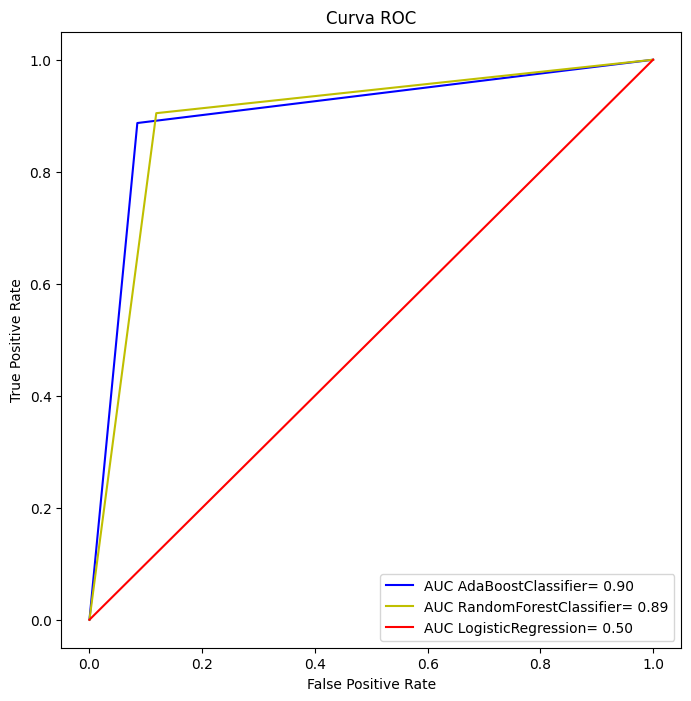

In [108]:
#Plot AUC-ROC
fpr1, tpr1, threshold1 = roc_curve(y_test, y_pred_ada_model)
roc_auc1 = auc(fpr1, tpr1)
fpr2, tpr2, threshold2 = roc_curve(y_test, y_pred_rforest_model)
roc_auc2 = auc(fpr2, tpr2)
fpr3, tpr3, threshold3 = roc_curve(y_test, y_pred_l_model)
roc_auc3 = auc(fpr3, tpr3) 

plt.figure(figsize=(8,8))
plt.title('Curva ROC')
plt.plot(fpr1, tpr1, 'b', label = 'AUC AdaBoostClassifier= %0.2f' % roc_auc1)
plt.plot(fpr2, tpr2, 'y', label = 'AUC RandomForestClassifier= %0.2f' % roc_auc2)
plt.plot(fpr3, tpr3, 'r', label = 'AUC LogisticRegression= %0.2f' % roc_auc3)

plt.legend(loc = 'lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()